# Import library and set base path

In [1]:
  # import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
from tqdm import tqdm_notebook as tqdm

basePath = os.path.join(os.getcwd(),"dataset")
currentPath = os.getcwd()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# File Preprocessing

### The original datasest is are arranged into "with_mask" and "without_mask" folder. The file path and label is append to the respective list

In [9]:
oriData = os.listdir(basePath)
oriList = [x for x in oriData if "face_dataset" in x]
print("original dataset folder = ",oriList)
category = {"without_mask":0, "with_mask":1}
print("category = ",category)

original dataset folder =  ['AFDB_face_dataset', 'AFDB_masked_face_dataset']
category =  {'without_mask': 0, 'with_mask': 1}


In [14]:
maskData =[]
nomaskData = []
labelMask = []
labelNoMask = []
for key,newKey in zip(oriData[:2],category):
    i = 0
    print("dataset = "+newKey + ", label = ",category[newKey])
    currPath = os.path.join(basePath,key)
    newPath = os.path.join(basePath,newKey)
    print("current path ={}\nnew path = {}\n ".format(currPath,newPath))
    if not os.path.exists(newPath):
        os.makedirs(newPath)
    fileList = glob(currPath+"\**\*.jpg")
    for file in fileList:
        dest = shutil.copy(file,newPath+"\\"+str(i)+".jpg")
        i+=1
        if (newKey == "without_mask" and key=="AFDB_face_dataset"):
            nomaskData.append(dest)
            labelNoMask.append(category[newKey])
        else:
            maskData.append(dest)
            labelMask.append(category[newKey])               

dataset = without_mask, label =  0
current path =C:\Users\KianAun\soft_facemask\dataset\AFDB_face_dataset
new path = C:\Users\KianAun\soft_facemask\dataset\without_mask
 
dataset = with_mask, label =  1
current path =C:\Users\KianAun\soft_facemask\dataset\AFDB_masked_face_dataset
new path = C:\Users\KianAun\soft_facemask\dataset\with_mask
 


In [15]:
print("total with mask images = ", len(labelMask))
print("total without mask images = ",len(labelNoMask))

total with mask images =  2118
total without mask images =  90468


# Save Record of data and label

### Use CSV to record the images path and labels

In [16]:
mask = {'path':maskData,'label':labelMask}
df1 = pd.DataFrame(mask, columns=['path','label'])
print (df1.head())

nomask = {'path':nomaskData, 'label':labelNoMask}
df2 = pd.DataFrame(nomask, columns=['path','label'])
print (df2.head())

                                                path  label
0  C:\Users\KianAun\soft_facemask\dataset\with_ma...      1
1  C:\Users\KianAun\soft_facemask\dataset\with_ma...      1
2  C:\Users\KianAun\soft_facemask\dataset\with_ma...      1
3  C:\Users\KianAun\soft_facemask\dataset\with_ma...      1
4  C:\Users\KianAun\soft_facemask\dataset\with_ma...      1
                                                path  label
0  C:\Users\KianAun\soft_facemask\dataset\without...      0
1  C:\Users\KianAun\soft_facemask\dataset\without...      0
2  C:\Users\KianAun\soft_facemask\dataset\without...      0
3  C:\Users\KianAun\soft_facemask\dataset\without...      0
4  C:\Users\KianAun\soft_facemask\dataset\without...      0


### save csv record

In [18]:
df1.to_csv(os.path.join(basePath,"mask_record.csv"))
df2.to_csv(os.path.join(basePath,"no_mask_record.csv"))

# MobileNet Preprocessing and store in .npy file

### Preprocess the images into same size 224x224 and using MobileNet preprocessor to process into needed format for MobileNetV2 training. The training dataset for mask and without mask should be balanced to avoid biased.

In [19]:
csvRecord = glob(basePath+"\*.csv")
data = []
dataLabel = []
for csvFile in csvRecord:
    print(csvFile)
    newdf = pd.read_csv(csvFile)
    newdf = newdf.sample(n=len(labelMask), random_state=2)
    
    print("filename = ",csvFile)
    for index,row in tqdm(newdf.iterrows(), total=newdf.shape[0]):
  
        try:            
            image = load_img(row["path"], target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)

            data.append(image)
            dataLabel.append(row["label"])

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image
            
 

C:\Users\KianAun\soft_facemask\dataset\mask_record.csv
filename =  C:\Users\KianAun\soft_facemask\dataset\mask_record.csv


<ipython-input-19-37100f8d1de3>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index,row in tqdm(newdf.iterrows(), total=newdf.shape[0]):



C:\Users\KianAun\soft_facemask\dataset\no_mask_record.csv
filename =  C:\Users\KianAun\soft_facemask\dataset\no_mask_record.csv


### label with binarizer

In [20]:
lb = LabelBinarizer()
labels = lb.fit_transform(dataLabel)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

print("visualize 5 new label value")
print("with mask \nold label =\n{}\nnew label=\n{}\n".format(dataLabel[0:5],labels[0:5]))
print("without mask\nold label =\n{}\nnew label=\n{}".format(dataLabel[-5:-1],labels[-5:-1]))

visualize 5 new label value
with mask 
old label =
[1, 1, 1, 1, 1]
new label=
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]

without mask
old label =
[0, 0, 0, 0]
new label=
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


### save the new label and processed images 

In [21]:
np.save('images.npy',data)
np.save('labels.npy',labels)

In [4]:
#testing the saved images and label
data=np.load('images.npy')
new_target=np.load('labels.npy')

In [5]:
print(new_target)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Declare Image Augmentation settings

In [6]:
labels = new_target
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


# Create model and training 

### Configure MobileNetV3 model network and train. 

In [10]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# load the MobileNetV2 network, ensuring the head FC layer sets are set off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of thethe base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
105/105 [==============================] - 62s 564ms/step - loss: 0.3152 - accuracy: 0.9085 - val_loss: 0.0956 - val_accuracy: 0.9906
Epoch 2/20
105/105 [==============================] - 58s 555ms/step - loss: 0.1055 - accuracy: 0.9774 - val_loss: 0.0487 - val_accuracy: 0.9929
Epoch 3/20
105/105 [==============================] - 60s 569ms/step - loss: 0.0702 - accuracy: 0.9842 - val_loss: 0.0364 - val_accuracy: 0.9965
Epoch 4/20
105/105 [==============================] - 60s 566ms/step - loss: 0.0583 - accuracy: 0.9857 - val_loss: 0.0298 - val_accuracy: 0.9965
Epoch 5/20
105/105 [==============================] - 59s 562ms/step - loss: 0.0504 - accuracy: 0.9854 - val_loss: 0.0278 - val_accuracy: 0.9965
Epoch 6/20
105/105 [==============================] - 62s 589ms/step - loss: 0.0454 - accuracy: 0.9872 - val_loss: 0.0241 - val_accuracy: 0.9965
Epoch 7/20
105/105 [==============================] - 59s 560ms/step - loss: 0.0

# Result evaluation and visualisation

### classification report

In [11]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=["with_mask","without_mask"]))

              precision    recall  f1-score   support

   with_mask       1.00      0.99      0.99       424
without_mask       0.99      1.00      0.99       424

    accuracy                           0.99       848
   macro avg       0.99      0.99      0.99       848
weighted avg       0.99      0.99      0.99       848



### loss and accuracy graph 

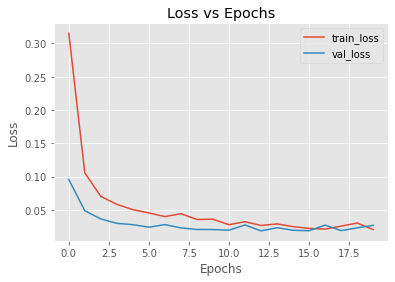

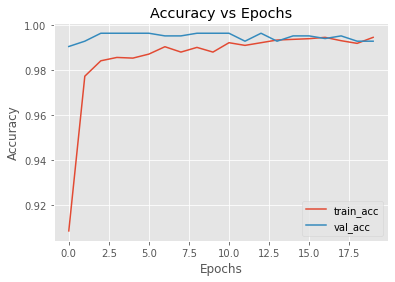

In [12]:
# plot the graph of loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(0)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend(loc="upper right")
plt.savefig(os.path.join(currentPath,"results\\loss_plot.png"))
plt.figure(1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig(os.path.join(currentPath,"results\\accuracy_plot.png"))

# Testing results

### Import library 

In [13]:
# import the necessary packages for face mask detection
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img

import numpy as np
import time
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
from pygame import mixer
from glob import glob

mixer.init()
sound = mixer.Sound(os.getcwd()+"\\FaceMask_detection_alarm.wav")

pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Images classifications with original datasets

### Original datasets is cropped images, therefore run this section of code which does not need face detection 

In [14]:
# some input from original dataset 
imgls = glob(os.getcwd()+"\\experiment\\dataset_input\\*.jpg")

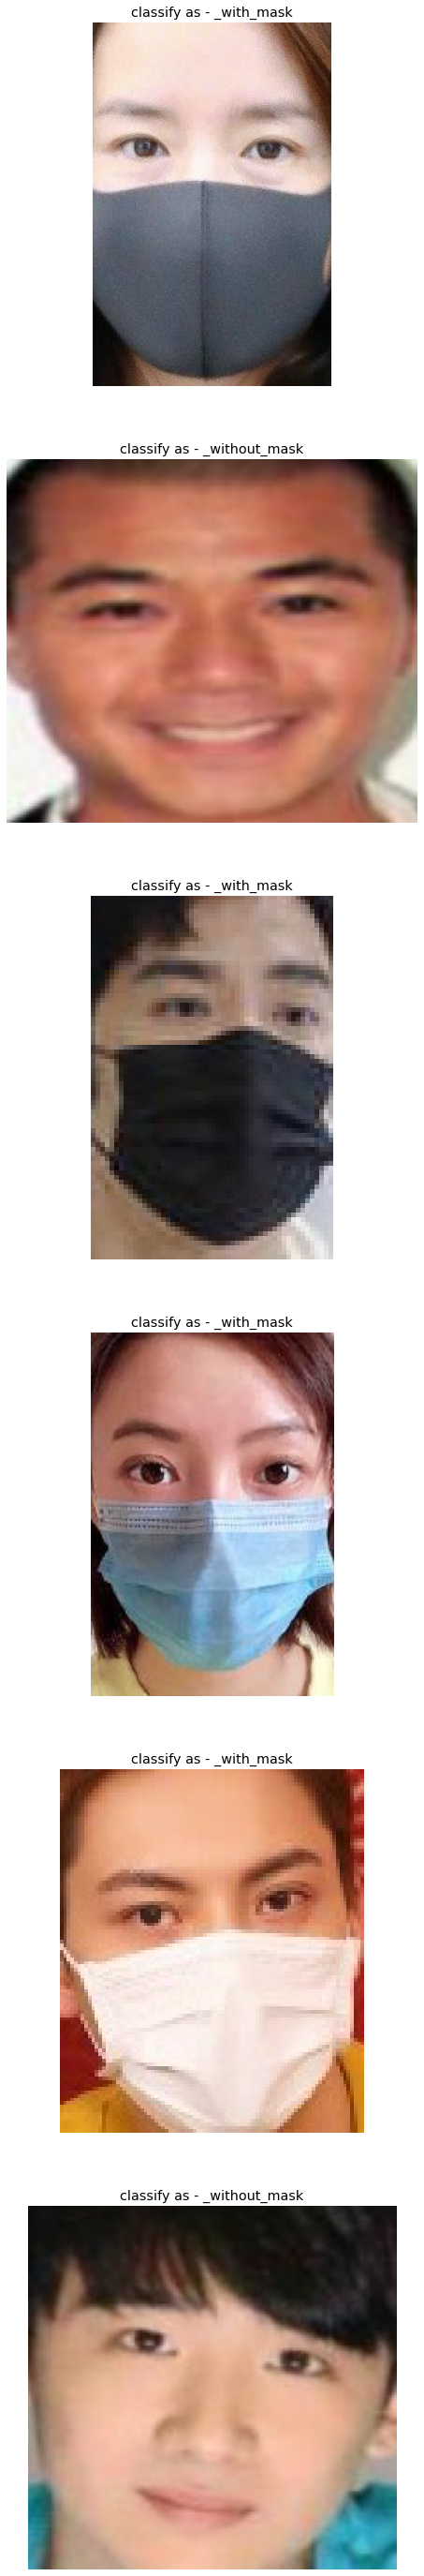

In [15]:
# load the face mask detector model from disk
maskClassifier = load_model("mask_detector.model")
predicted = []

#set the images size plot
rows = len(imgls)
f = plt.figure()
f.set_figheight(50)
f.set_figwidth(50)

#loop through the file path list to get the images
for num, file in enumerate(imgls):
    OriImage = Image.open(file)
    #preprocess input images 
    image = OriImage.resize((224,224))  
    image = np.asarray(image)
    image = preprocess_input(image)  
    image = np.reshape(image,[1,224,224,3])
    
    #predict and get the results
    prediction = maskClassifier.predict(image)
    prediction = np.argmax(prediction, axis=1)
    
    #plot out to visualize
    f.add_subplot(rows,1,num+1)
    predictName = ("_with_mask" if prediction == 1 else "_without_mask")
    plt.title("classify as - "+ predictName)
    plt.axis('off')
    plt.imshow(OriImage)
    
    #save the output images with filename added "with_mask" or "without_mask" prediction
    OutFile = file.replace("input","output").replace(".jpg",predictName)+".jpg"
    OriImage.save(OutFile)
    

## Testing webcam with face detector

### Create necessary function for frame/images prediction

In [16]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
        (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            # extract the face ROI, convert it from BGR to RGB channel ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)


### Start live webcam face mask detection with alert sound

In [17]:
# load our serialized face detector model from disk
prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
maskNet = load_model("mask_detector.model")

# initialize the video stream
print("[INFO] starting video stream...")

# setup your video camera
cap = cv2.VideoCapture(0)
frame_width = int(cap.set(3, 1500))
frame_height = int(cap.set(4, 1500))

# loop over the frames from the video stream
while True:

    ret, frame = cap.read()
  
    if ret:
        # detect faces in the frame and determine if they are wearing a
        # face mask or not
        (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

        # loop over the detected face locations and their corresponding locations
        for (box, pred) in zip(locs, preds):
            # unpack the bounding box and predictions
            (startX, startY, endX, endY) = box
            (withoutMask,mask) = pred

            # determine the class label and color we'll use to draw
            # the bounding box and text
            label = "Mask" if mask > withoutMask else "No Mask"
            if label == "Mask":
                color = (0, 255, 0) 
                sound.stop()
            else:
                sound.play()
                color = (0, 0, 255)

            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

            # display the label and bounding box rectangle on the output frame
            cv2.putText(frame, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

        # show the output frame
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            sound.stop()
            break
            
    else:
        break
        
print("[INFO] ended video stream...")
cap.release()        
# do a bit of cleanup
cv2.destroyAllWindows()


[INFO] starting video stream...
[INFO] ended video stream...


### Experiment with passport images / images from dataset

In [18]:
# declare a list of inputs for experiment

# passport input 
outputPath = "experiment\\passport_output\\"
imgls = glob(os.getcwd()+"\\experiment\\passport_input\\*.jpg")


In [19]:
# load our serialized face detector model from disk

for file in imgls:
    #OpenCV users BGR instead of RGB
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    prototxtPath = r"face_detector\deploy.prototxt"
    weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
    faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

    # load the face mask detector model from disk
    maskNet = load_model("mask_detector.model")
 
    (locs, preds) = detect_and_predict_mask(img, faceNet, maskNet)
    
  
    
    # loop over the detected face locations and their corresponding locations
    for (box, pred) in zip(locs, preds):
        
        labelName =""
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (withoutMask,mask) = pred

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        if label == "Mask":
            labelName = "_with_mask"
            color = (0, 255, 0) 
            sound.stop()
        else:
            labelName = "_without_mask"
            sound.play()
            color = (255, 0, 0)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output
        # images
        cv2.putText(img, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 3)
        cv2.rectangle(img, (startX, startY), (endX, endY), color, 8)

        imgOut =outputPath +os.path.basename(file).replace(".jpg",labelName)+".jpg"

        savePath = os.path.join(os.getcwd(),imgOut)
        
        print(savePath)
        
    image = Image.fromarray(img)
    image.show()
    image.save(savePath)

# (1, 1, 200, 7)
# (200, 151, 3)
# <class 'numpy.ndarray'>

C:\Users\KianAun\soft_facemask\experiment\passport_output\tan_without_mask.jpg
C:\Users\KianAun\soft_facemask\experiment\passport_output\tan_black_with_mask.jpg
C:\Users\KianAun\soft_facemask\experiment\passport_output\tan_gas_with_mask.jpg
C:\Users\KianAun\soft_facemask\experiment\passport_output\tan_KN95_with_mask.jpg
C:\Users\KianAun\soft_facemask\experiment\passport_output\tan_N95_with_mask.jpg
C:\Users\KianAun\soft_facemask\experiment\passport_output\tan_surgical_with_mask.jpg


### visualize experiment output images

In [20]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

#retrieve the file path
path = os.path.join(currentPath,"experiment\\passport_output\\")
fileList =  glob.glob(path+"*.jpg")

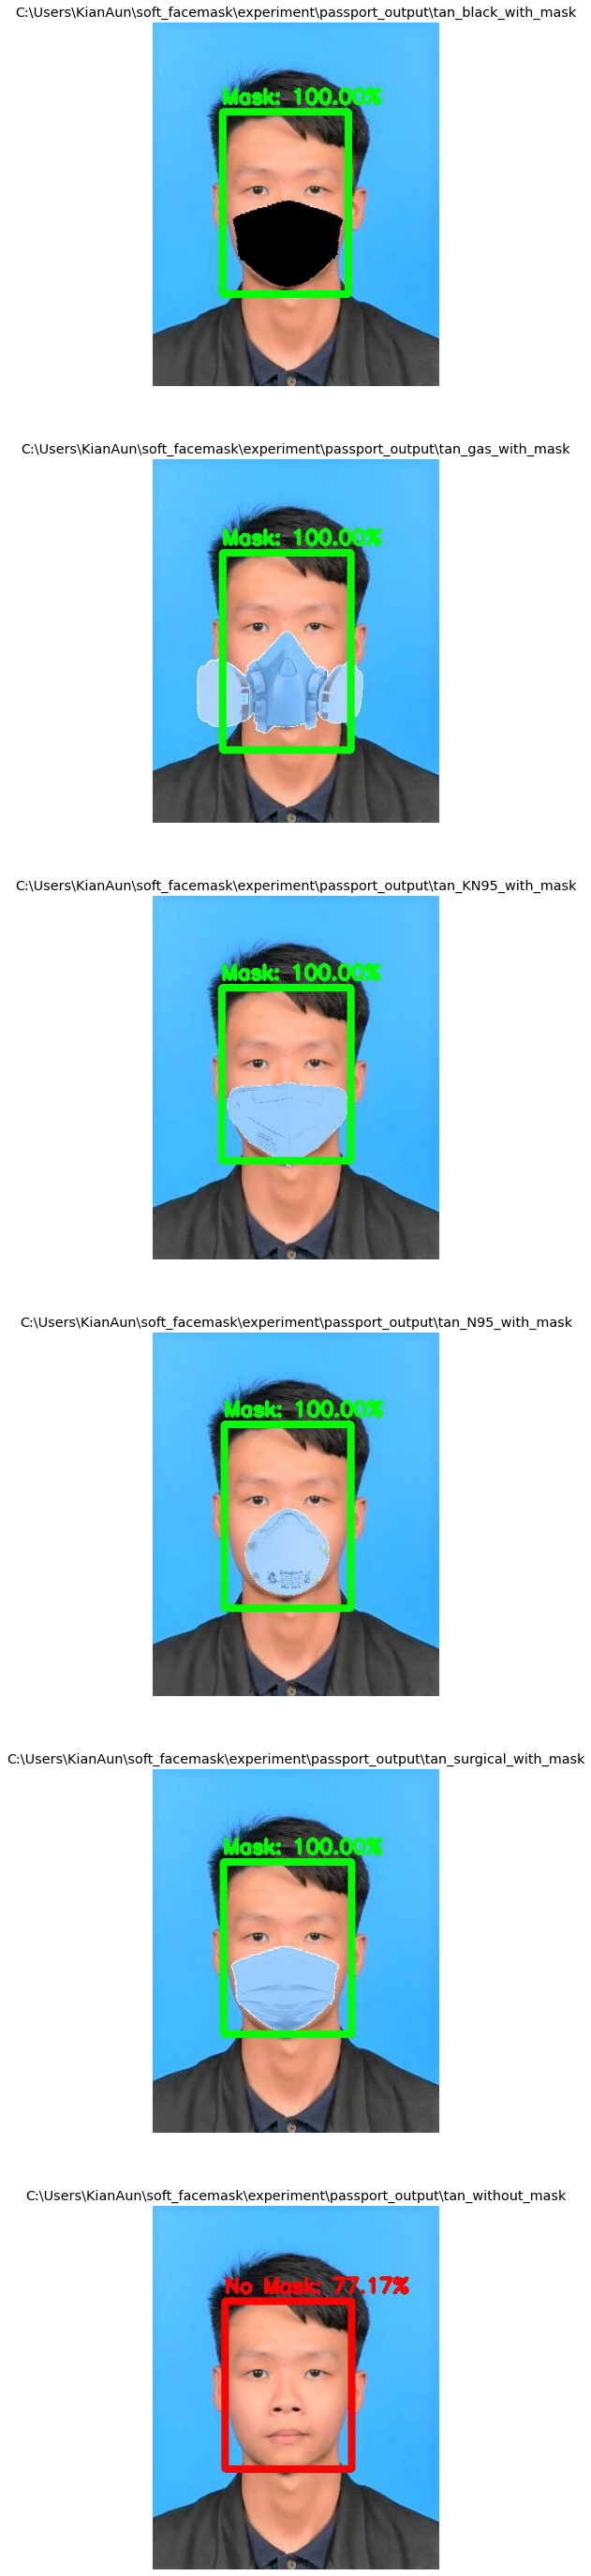

In [21]:
#set the images size
rows = len(fileList)
f = plt.figure()
f.set_figheight(50)
f.set_figwidth(50)

# plot all images
for num, x in enumerate(fileList):
    img = Image.open(x)
    f.add_subplot(rows,1,num+1)
    plt.title(x.split('.')[0])
    plt.axis('off')
    plt.imshow(img)